<a href="https://colab.research.google.com/github/caixinya/Projects/blob/main/Credit_Card_Fraud_Detection_Caixin_Yang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
import matplotlib.pyplot as plt

# 1. Load Data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [3]:
import io
df = pd.read_csv(io.StringIO(uploaded['creditcard.csv'].decode('utf-8')))

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.shape

(284807, 31)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [10]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

# 2. Split and Resample Data

## 2.1 Split Training and Testing Dataset with a Stratified Method

In [11]:
x = df.drop(['Class','Time'],axis = 1).values
y = df['Class'].values

x = np.array(x)
y = np.array(y)

In [12]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(x,y):
    print('Train:', train_index,'Test:',test_index)
    x_train,x_test = x[train_index],x[test_index]
    y_train,y_test = y[train_index],y[test_index]

Train: [ 36001  12844   2873 ... 269968 175960  47973] Test: [159949  15295 260353 ... 211932  70523  97767]
Train: [ 46703  37864  53704 ... 195186 261438  51416] Test: [121014  92252 260341 ... 181799  82326 224004]
Train: [167230 199227 240655 ... 226803 125192  34695] Test: [ 77137 250389 162020 ...  29774 146893 221549]
Train: [  8038  60161 193863 ... 217105 207595   5194] Test: [ 70283 106113  44216 ...  27576 145659 248227]
Train: [ 73271  12342  27439 ...  85256 253556 274487] Test: [229938  58436 277040 ...  62592 245003 107389]


In [15]:
print('train shape:',x_train.shape,y_train.shape)
print('test shape:',x_test.shape,y_test.shape)
print('fruad cases:',np.sum(y_train==1),np.sum(y_test==1))

train shape: (227845, 29) (227845,)
test shape: (56962, 29) (56962,)
fruad cases: 394 98


## 2.2 Upsampling Training Data

In [16]:
type(x_train),type(y_train)

(numpy.ndarray, numpy.ndarray)

In [17]:
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
train = pd.concat([x_train,y_train],axis=1)

In [18]:
train.columns = df.columns[1:]

In [19]:
train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.426154,0.064759,2.034158,-0.265603,-1.092591,-0.281123,0.195237,0.131432,0.471432,-0.742013,-0.900805,-0.563352,-0.941352,-0.250173,0.602176,0.342182,-0.188794,0.211834,0.066517,0.135000,0.187582,0.439275,0.069215,0.443261,-0.218428,1.068787,-0.049993,0.025481,100.00,0
1,1.166853,-0.247931,0.549775,0.166218,-0.711743,-0.456924,-0.488822,0.041760,1.697831,-0.309506,1.730897,-2.887524,-0.431462,2.185847,0.040721,0.818455,0.101872,0.739687,0.170749,-0.133222,-0.249949,-0.714633,0.039977,-0.062051,0.021172,0.839272,-0.122856,-0.006023,49.95,0
2,-0.643022,0.273467,1.708871,0.075233,-0.015607,-0.924860,0.590625,-0.083470,0.024000,-0.849202,-0.588534,0.775241,0.605020,-0.475577,-1.133477,-0.328836,-0.087434,-0.663261,-0.501951,0.055218,0.074493,0.262166,-0.018378,0.773391,0.127824,0.244459,-0.013017,0.041442,48.79,0
3,1.931794,-1.203632,-0.465100,-0.422098,-0.834082,0.515066,-1.074884,0.072867,0.334211,0.541189,-1.551769,0.535559,1.797563,-0.648091,0.768077,-0.953151,-0.714327,1.635955,-0.876907,-0.291043,-0.285607,-0.367182,0.206915,-0.050278,-0.396812,-0.429337,0.067211,-0.002385,109.84,0
4,-1.713437,1.992477,-1.282566,-0.826902,-0.414038,-0.709109,-0.225639,1.313910,-0.174464,0.008252,0.054034,1.107444,-0.043045,1.073849,-1.069899,0.480132,-0.256911,-0.118963,0.179061,0.021643,-0.196031,-0.633477,0.190692,-0.491007,-0.266904,0.171153,0.187619,0.072414,8.94,0


In [21]:
train_minor = train[train.Class == 1]
train_major = train[train.Class == 0]

print('minor class in the training dataset:',train_minor['Class'].value_counts())
print('major class in the training dataset:',train_major['Class'].value_counts())

minor class in the training dataset: 1    394
Name: Class, dtype: int64
major class in the training dataset: 0    227451
Name: Class, dtype: int64


In [22]:
train_minor_up = resample(train_minor, replace=True, n_samples = 227451,random_state=123)

In [23]:
train = pd.concat([train_major,train_minor_up])
train.Class.value_counts()

1    227451
0    227451
Name: Class, dtype: int64

In [24]:
x_train = train.drop(['Class'], axis = 1).values
y_train = train['Class'].values

In [25]:
x_train.shape, y_train.shape, np.sum(y_train==1)

((454902, 29), (454902,), 227451)

# 3. ANN Model

## 3.1 Build Metrics & ANN Model

In [26]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [28]:
model = Sequential()
model.add(Dense(16, activation='tanh', input_dim=29))
model.add(Dropout(0.1))
model.add(Dense(4, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

## 3.2 Fit the Model

In [34]:
model.fit(x_train,y_train, epochs=10, batch_size=16)
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=1)
print(f1_score)

Epoch 1/10
28432/28432 [==============================] - 36s 1ms/step - loss: 0.0525 - accuracy: 0.9818 - f1_m: 0.9806 - precision_m: 0.9818 - recall_m: 0.9820
Epoch 2/10
28432/28432 [==============================] - 37s 1ms/step - loss: 0.0455 - accuracy: 0.9844 - f1_m: 0.9833 - precision_m: 0.9836 - recall_m: 0.9852
Epoch 3/10
28432/28432 [==============================] - 36s 1ms/step - loss: 0.0434 - accuracy: 0.9853 - f1_m: 0.9843 - precision_m: 0.9846 - recall_m: 0.9861
Epoch 4/10
28432/28432 [==============================] - 36s 1ms/step - loss: 0.0416 - accuracy: 0.9859 - f1_m: 0.9850 - precision_m: 0.9855 - recall_m: 0.9864
Epoch 5/10
28432/28432 [==============================] - 36s 1ms/step - loss: 0.0405 - accuracy: 0.9863 - f1_m: 0.9853 - precision_m: 0.9856 - recall_m: 0.9870
Epoch 6/10
28432/28432 [==============================] - 36s 1ms/step - loss: 0.0389 - accuracy: 0.9871 - f1_m: 0.9863 - precision_m: 0.9865 - recall_m: 0.9879
Epoch 7/10
28432/28432 [==========

In [35]:
y_predict = model.predict_classes(x_test)
confusion_matrix(y_test,y_predict)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[56460,   404],
       [   14,    84]])

In [36]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.17      0.86      0.29        98

    accuracy                           0.99     56962
   macro avg       0.59      0.93      0.64     56962
weighted avg       1.00      0.99      1.00     56962



## 3.3 Learning Curve

In [39]:
model.compile(optimizer = Adam(lr=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test),verbose=1)

Epoch 1/10
14216/14216 [==============================] - 20s 1ms/step - loss: 0.0315 - accuracy: 0.9894 - val_loss: 0.0245 - val_accuracy: 0.9929
Epoch 2/10
14216/14216 [==============================] - 20s 1ms/step - loss: 0.0300 - accuracy: 0.9901 - val_loss: 0.0240 - val_accuracy: 0.9927
Epoch 3/10
14216/14216 [==============================] - 19s 1ms/step - loss: 0.0298 - accuracy: 0.9902 - val_loss: 0.0217 - val_accuracy: 0.9935
Epoch 4/10
14216/14216 [==============================] - 20s 1ms/step - loss: 0.0293 - accuracy: 0.9903 - val_loss: 0.0220 - val_accuracy: 0.9936
Epoch 5/10
14216/14216 [==============================] - 19s 1ms/step - loss: 0.0283 - accuracy: 0.9906 - val_loss: 0.0225 - val_accuracy: 0.9934
Epoch 6/10
14216/14216 [==============================] - 20s 1ms/step - loss: 0.0291 - accuracy: 0.9906 - val_loss: 0.0213 - val_accuracy: 0.9938
Epoch 7/10
14216/14216 [==============================] - 19s 1ms/step - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0

In [40]:
def learningcurve(history,epoch):
    epoch_range = range(1,epoch+1)
    plt.plot(epoch_range,history.history['accuracy'])
    plt.plot(epoch_range,history.history['val_accuracy'])
    plt.title('Model_Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'],loc='best')
    plt.show()
    
    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title('Model_Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'],loc='best')
    plt.show()

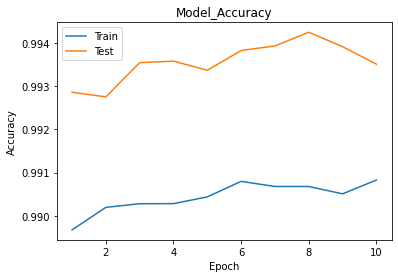

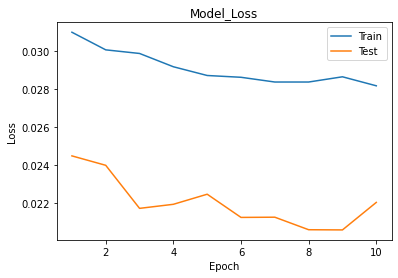

In [41]:
learningcurve(history,10)

# 4. Logistic Regression

In [42]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
lr_prediction = logreg.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test,lr_prediction))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962



# 5. Random Forest Classification

In [44]:
clf = RandomForestClassifier()
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
clf_y_prediction = clf.predict(x_test)
print(classification_report(y_test,clf_y_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.73      0.83        98

    accuracy                           1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



# 6. ROC Curve

In [46]:
clf_probs = clf.predict_proba(x_test)[:, 1]
lr_probs = logreg.predict_proba(x_test)[:,1]
ns_probs = [0 for _ in range(len(x_test))]

In [48]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
clf_fpr, clf_tpr, _ = roc_curve(y_test, clf_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

In [47]:
ann_probs = model.predict_proba(x_test)
ann_fpr, ann_tpr, _ = roc_curve(y_test, ann_probs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


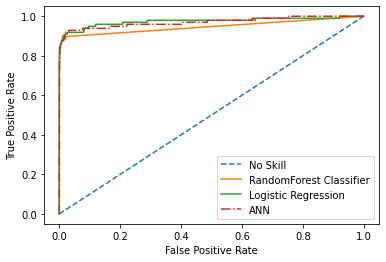

In [49]:
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(clf_fpr, clf_tpr, linestyle='-', label='RandomForest Classifier')
pyplot.plot(lr_fpr, lr_tpr, linestyle='-', label='Logistic Regression')
pyplot.plot(ann_fpr, ann_tpr, linestyle='-.', label='ANN')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()